# eager Execution
本教程介绍了如何使用机器学习按品种对鸢尾花进行归类。它利用 TensorFlow 的 Eager Execution 来 (1) 构建模型，(2) 使用样本数据训练该模型，并 (3) 利用该模型对未知数据进行预测。

In [1]:
from __future__ import  absolute_import,division,print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("tensorflow version:{}".format(tf.VERSION))
print("Eager Excution:{}".format(tf.executing_eagerly()))

D:\Anaconda3.5.2.0\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow version:1.10.0
Eager Excution:True


# 下载数据集
使用 tf.keras.utils.get_file 函数下载训练数据集文件。该函数会返回下载文件的文件路径。

In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),origin=train_dataset_url)
print("Local copy of the dataset file:{}".format(train_dataset_fp))

Local copy of the dataset file:C:\Users\THINK\.keras\datasets\iris_training.csv


# 检查数据

In [3]:
#!head -n5 {train_dataset_fp}

# 解析CSV数据集

In [4]:
def parse_csv(line):
    record = [[0.],[0.],[0.],[0.],[0]]  ## sets field types
    #Convert CSV records to tensors. Each column maps to one tensor.
    parsed_line =tf.decode_csv(line,record) 
    #First 4 fields are features, combine into single tensor
    features = tf.reshape(parsed_line[:-1],shape=(4,))
    #Last field is the label
    label = tf.reshape(parsed_line[-1],shape=())
    return features, label


# 创建训练tf.data.Dataset

In [5]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([6.5 3.  5.2 2. ], shape=(4,), dtype=float32)
example label: tf.Tensor(2, shape=(), dtype=int32)


# 使用keras创建模型

In [6]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

# 损失函数和梯度函数

In [7]:
def loss(model,x ,y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y,logits=y_)

#grad 函数使用 loss 函数和 tf.GradientTape 来记录计算梯度
def grad(model,inputs,targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model,inputs,targets)
    return tape.gradient(loss_value,model.variables)

# 创建优化器

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

# 循环训练

In [14]:
## Note: Rerunning this cell uses the same model variables

#keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 301

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    #Train Loop - using batches of 32
    for x,y in train_dataset:
        #optimizer the model
        grads = grad(model,x,y)
        optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

        
        #Track progre
        epoch_loss_avg(loss(model,x,y))#addd current batch loss
        #compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x),axis =1,output_type=tf.int32),y)
    #ending epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch%50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}， Accuracy: {:3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 0.084， Accuracy: 97.500000%
Epoch 050: Loss: 0.077， Accuracy: 98.333333%
Epoch 100: Loss: 0.079， Accuracy: 99.166667%
Epoch 150: Loss: 0.067， Accuracy: 99.166667%
Epoch 200: Loss: 0.064， Accuracy: 99.166667%
Epoch 250: Loss: 0.066， Accuracy: 99.166667%
Epoch 300: Loss: 0.064， Accuracy: 97.500000%


# 可视化损失函数随时间推移而变化的情况

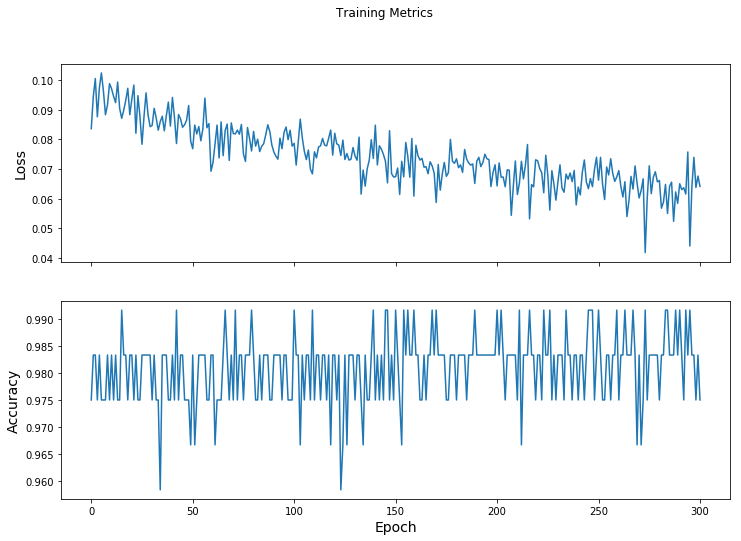

In [15]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

# 评估模型的效果

In [16]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)         # skip header row
test_dataset = test_dataset.map(parse_csv)  # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)   # randomize
test_dataset = test_dataset.batch(32)       # use the same batch size as the training set

# 根据测试数据集评估模型

In [17]:
test_accuracy = tfe.metrics.Accuracy()

for (x,y) in test_dataset:
    prediction = tf.argmax(model(x),axis=1,output_type=tf.int32)
    test_accuracy(prediction,y)
print("Test set accuracy :{:.3%}".format(test_accuracy.result()))

Test set accuracy :96.667%


# 使用经过训练的模型进行预测
0：山鸢尾
1：变色鸢尾
2：维吉尼亚鸢尾

In [18]:
class_ids =  ["Iris setosa","Iris versicolor","Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i,logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    name = class_ids[class_idx]
    print("Exmaple{}prediction: {}".format(i,name))

Exmaple0prediction: Iris setosa
Exmaple1prediction: Iris versicolor
Exmaple2prediction: Iris virginica
